# Definition of the model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from constants import *
import datasets
from visualization import *
import time
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


In [2]:
class BeatTracker(nn.Module):
    
    def __init__(self, hidden_size=128, num_layers=2):
        super(BeatTracker, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
                        nb, 
                        hidden_size, 
                        num_layers, 
                        bidirectional=True, 
                        dropout=0.5,
                        batch_first=True)
        self.hid_to_beat = nn.Linear(2 * hidden_size, 2)
        self.hidden = None
        
        self.loss_function = nn.NLLLoss()
        
        self.lr = 0.001
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, spec):
        x = self.lstm(spec)[0]
        x = self.hid_to_beat(x)
        x = F.log_softmax(x, dim=-1)
        return x
    
    def set_lr(self, lr):
        self.lr = lr
        for p in self.optimizer.param_groups:
            p['lr'] = lr
    
    def loss(self, spec, onsets, isbeat):
        output = self(spec)
        output = output[onsets == 1]
        target = isbeat[onsets == 1]
        loss = self.loss_function(output, target)
        return loss

    def loss_from_dataset(self, dataset, batch_size=32):
        dataloader = DataLoader(dataset, batch_size=batch_size)
        loss = 0
        with torch.no_grad():
            loss = 0
            for specs, onsets, isbeat in dataloader:
                loss += self.loss(specs, onsets, isbeat).item()
            loss /= len(dataloader)
        return loss
    
    def learn(self, spec, onsets, isbeat):
        self.optimizer.zero_grad()
        output = self(spec)
        output = output[onsets == 1]
        target = isbeat[onsets == 1]
        loss = self.loss_function(output, target)
        loss.backward()
        self.optimizer.step()
        
        predic = torch.argmax(output, dim=1)
        accuracy = torch.sum(predic == target).item() / predic.shape.numel()
        
        return loss.item(), accuracy
    
    def fit(self, dataset, validset, batch_size=1, epochs=1):
        len_dataloader = -(-len(dataset) // batch_size)  # quick ceiling function
        loss_hist = np.zeros((epochs, len_dataloader))
        accu_hist = np.zeros((epochs, len_dataloader))
        valid_hist= np.zeros(epochs)
        for e in range(epochs):
            start = time.time()
            
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, (spec, onsets, isbeat) in enumerate(dataloader):
                loss, accuracy = self.learn(spec, onsets, isbeat)
                loss_hist[e, i] = loss
                accu_hist[e, i] = accuracy
            
            valid_hist[e] = self.loss_from_dataset(validset)
            
            end = time.time()
            t = end - start
            eta = str(datetime.timedelta(seconds=int(t * (epochs - e - 1))))
            print(f'| Epoch: {e + 1:{len(str(epochs))}} | ', end='')
            print(f'Loss: {np.mean(loss_hist[e]):7.4f} | ', end='')
            print(f'Valid loss: {valid_hist[e]:7.4f} | ', end='')
            print(f'Accuracy: {np.mean(accu_hist[e]):5.4f} | ', end='')
            print(f'{t / len(dataloader):.2f} s/b | Eta: {eta} |')
        return loss_hist, accu_hist, valid_hist
    
    def predict(self, specs, onsets):
        """So far only works if batch_size = 1"""
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            pred_t = torch.argmax(output, dim=1)
            onsets_frames = np.argwhere(onsets.squeeze(0) == 1).squeeze(0)
            beats_frames = onsets_frames[pred_t == 1]
            pred = torch.zeros_like(onsets)
            pred[:, beats_frames] = 1
        return pred
    
    def evaluate(self, specs, onsets, isbeat):
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            target = isbeat[onsets == 1]
            predic = torch.argmax(output, dim=1)
            
            tn = torch.sum((predic == 0) & (target == 0)).item()
            fp = torch.sum((predic == 1) & (target == 0)).item()
            fn = torch.sum((predic == 0) & (target == 1)).item()
            tp = torch.sum((predic == 1) & (target == 1)).item()
        return tn, fp, fn, tp
    
    def evaluate_from_dataset(self, dataset, batch_size=16):
        dataloader = DataLoader(dataset, batch_size=batch_size)
        ttn = 0
        tfp = 0
        tfn = 0
        ttp = 0
        for specs, onsets, isbeat in dataloader:
            tn, fp, fn, tp = self.evaluate(specs, onsets, isbeat)
            ttn += tn
            tfp += fp
            tfn += fn
            ttp += tp
        return ttn, tfp, tfn, ttp
    
    def freeze(self):
        for p in self.parameters():
            p.requires_grad = False
            
    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad = True

class ToTensor(object):
    
    def __call__(self, sample):
        spec_np, onsets_np, isbeat_np = sample
        
        # Normalize to [-1, 1]
        spec_np = 2 * (spec_np - spec_np.min()) / (spec_np.max() - spec_np.min()) - 1
        spec = torch.tensor(spec_np.T, dtype=torch.float, device=device)
        
        onsets = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        isbeat = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        
        onsets[onsets_np] = 1
        isbeat[onsets_np[isbeat_np == 1]] = 1
        
        return spec, onsets, isbeat

totensor = ToTensor()
    
def beat_track(isbeat):
    onset_envelope = isbeat.squeeze(0).numpy()
    tempo, bt = librosa.beat.beat_track(
                            sr=sr, 
                            onset_envelope=onset_envelope, 
                            hop_length=hl, 
                            tightness=800)
    return bt

# Datasets

Take a subset of the GTZAN dataset preprocessed using `preprocess-GTZAN` and split it into a train set and a validation set.

In [8]:
dataset = datasets.GTZAN(nb_files=4)

Or also the BALLROOM dataset

In [9]:
dataset = datasets.BALLROOM(nb_files=4)

Or combine both.

Visualize an example.

In [10]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
spec, onsets, isbeat = dataset[i]
beats = dataset.get_beats(i)

5/12


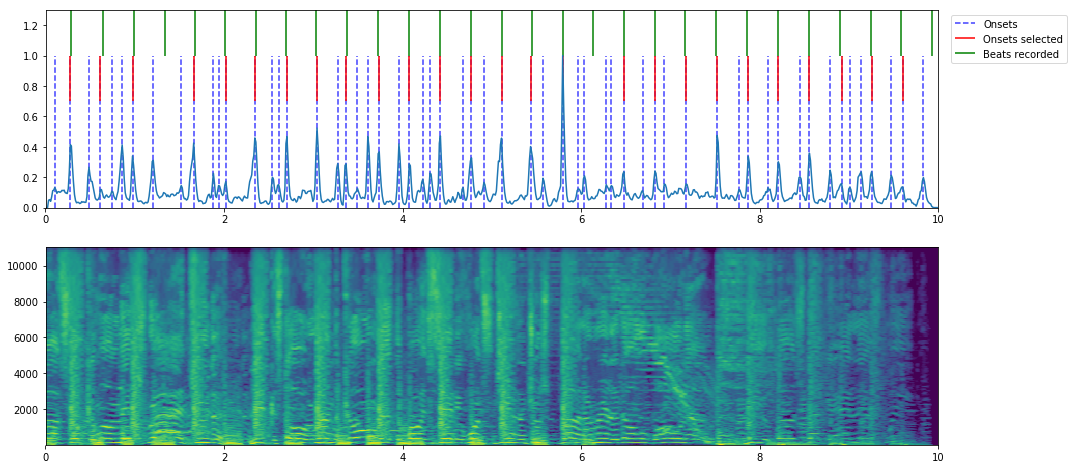

In [11]:
showdata(spec, onsets, isbeat, beats)

# Find learning rate

In [9]:
model = BeatTracker()
model.to(device)

BeatTracker(
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (hid_to_beat): Linear(in_features=256, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

Either GTZAN

In [10]:
dataset = datasets.GTZAN(nb_files=4, transform=totensor)

Or BALLROOM

In [12]:
dataset = datasets.BALLROOM(nb_files=4, transform=totensor)

Or both

In [27]:
dataset = datasets.GTZAN(nb_files=4, transform=totensor) + datasets.BALLROOM(nb_files=4, transform=totensor)

Make an array of learning rates.

In [28]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(0, 10, 10 / n_mb))[::-1]

8 mini batches


Then find lr

In [29]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    print(f'{i + 1}/{n_mb}')
    model.set_lr(lr[i])
    loss, accuracy = model.learn(specs, onsets, isbeat)
    losses[i] = loss

1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8


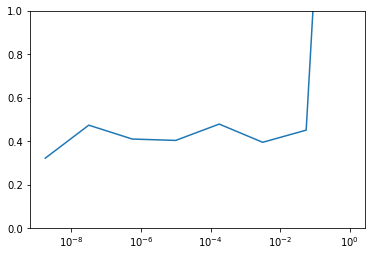

In [31]:
plt.ylim(0, 1)
plt.semilogx(lr, losses);

# Training of the model

In [41]:
model = BeatTracker()
model.to(device)
print_params(model)
model.eval()
model.freeze()

 ----------------------------------------------------------
| lstm.weight_ih_l0            | [512, 256]   |    131,072 |
| lstm.weight_hh_l0            | [512, 128]   |     65,536 |
| lstm.bias_ih_l0              | [512]        |        512 |
| lstm.bias_hh_l0              | [512]        |        512 |
| lstm.weight_ih_l0_reverse    | [512, 256]   |    131,072 |
| lstm.weight_hh_l0_reverse    | [512, 128]   |     65,536 |
| lstm.bias_ih_l0_reverse      | [512]        |        512 |
| lstm.bias_hh_l0_reverse      | [512]        |        512 |
| lstm.weight_ih_l1            | [512, 256]   |    131,072 |
| lstm.weight_hh_l1            | [512, 128]   |     65,536 |
| lstm.bias_ih_l1              | [512]        |        512 |
| lstm.bias_hh_l1              | [512]        |        512 |
| lstm.weight_ih_l1_reverse    | [512, 256]   |    131,072 |
| lstm.weight_hh_l1_reverse    | [512, 128]   |     65,536 |
| lstm.bias_ih_l1_reverse      | [512]        |        512 |
| lstm.bias_hh_l1_reverse

Split the dataset into training and validation.

In [42]:
p = 0.8
train_size = int(p * len(dataset))
indices = list(np.random.permutation(len(dataset)))
trainset = Subset(dataset, indices[:train_size])
validset = Subset(dataset, indices[train_size:])

print(f'Train size: {len(trainset)}')
print(f'Valid size: {len(validset)}')

Train size: 19
Valid size: 5


Evaluate

In [43]:
confusion(*model.evaluate_from_dataset(validset))

 -------------------
| tp: 106 | fp: 162 |
| fn:   0 | tn:   1 |
 -------------------
Precision: 0.3955
   Recall: 1.0000
 Accuracy: 0.3978


In [44]:
confusion(*model.evaluate_from_dataset(trainset))

 -------------------
| tp: 392 | fp: 750 |
| fn:   4 | tn:   9 |
 -------------------
Precision: 0.3433
   Recall: 0.9899
 Accuracy: 0.3472


Train

In [45]:
model.unfreeze()
model.train();

In [47]:
lost_hist, accu_hist, valid_hist = model.fit(trainset, validset, batch_size=4, epochs=3)

| Epoch: 1 | Loss:  0.6270 | Valid loss:  0.6637 | Accuracy: 0.6301 | 2.04 s/b | Eta: 0:00:20 |
| Epoch: 2 | Loss:  0.5429 | Valid loss:  0.5106 | Accuracy: 0.7416 | 2.00 s/b | Eta: 0:00:10 |
| Epoch: 3 | Loss:  0.5036 | Valid loss:  0.4952 | Accuracy: 0.7613 | 2.00 s/b | Eta: 0:00:00 |


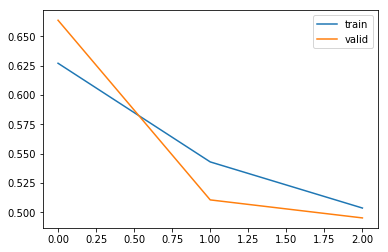

In [48]:
plt.plot(np.mean(lost_hist, axis=1), label='train')
plt.plot(valid_hist, label='valid')
plt.legend();

Reevaluate

In [49]:
model.eval()
model.freeze()

In [50]:
confusion(*model.evaluate_from_dataset(validset))

 -------------------
| tp:  53 | fp:  13 |
| fn:  53 | tn: 150 |
 -------------------
Precision: 0.8030
   Recall: 0.5000
 Accuracy: 0.7546


In [51]:
confusion(*model.evaluate_from_dataset(trainset))

 -------------------
| tp: 229 | fp:  85 |
| fn: 167 | tn: 674 |
 -------------------
Precision: 0.7293
   Recall: 0.5783
 Accuracy: 0.7818


Save

In [ ]:
#torch.save(model.state_dict(), './data/model_02.pt')

# Test

In [52]:
from IPython.display import Audio

def unibatch(spec_np, onsets_np, isbeat_np):
    """ Get a minibatch of one sample from the original numpy data."""
    spec, onsets, isbeat = totensor((spec_np, onsets_np, isbeat_np))
    spec = spec.unsqueeze(0)
    onsets = onsets.unsqueeze(0)
    isbeat = isbeat.unsqueeze(0)
    return spec, onsets, isbeat

Load the pretrained model and freeze its parameters.

In [ ]:
model = BeatTracker(hidden_size=256, num_layers=3)
model.load_state_dict(torch.load('./data/model_03.pt', map_location=device))
model.eval()
model.freeze()

Take a dataset

In [54]:
dataset = datasets.BALLROOM(nb_files=4)

Take a random sample

In [55]:
i = np.random.randint(len(dataset))
spec_np, onsets_np, isbeat_np = dataset[i]
beats_np = dataset.get_beats(i)

Compute the beat track from the RNN algorithm and compare with librosa and ground truth.

In [56]:
# RNN
spec, onsets, isbeat = unibatch(spec_np, onsets_np, isbeat_np)
pred = model.predict(spec, onsets)
bt = beat_track(pred)
bt_times = librosa.frames_to_time(bt, sr, hl)

/anaconda3/envs/audio/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [57]:
# Librosa
onset_envelope = librosa.onset.onset_strength(S=spec_np)
tempo, bt_lib  = librosa.beat.beat_track(onset_envelope=onset_envelope)
bt_lib_times   = librosa.frames_to_time(bt_lib, sr, hl)

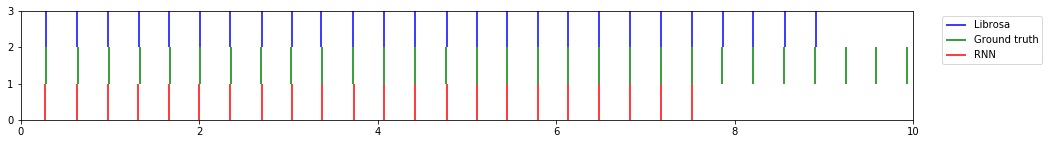

In [58]:
plt.figure(figsize=(16, 2))
plt.vlines(bt_lib_times, 2, 3, color='b', label='Librosa')
plt.vlines(beats_np, 1, 2, color='g', label='Ground truth')
plt.vlines(bt_times, 0, 1, color='r', label='RNN')
plt.xlim(0, 10)
plt.ylim(0, 3)
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1));

Listen to the three different beat tracks.

In [59]:
wav = dataset.get_wav(i)
Audio(wav, rate=sr)

In [60]:
# RNN
click = librosa.clicks(bt_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [61]:
# Librosa
click = librosa.clicks(bt_lib_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [62]:
# Ground truth (sort of)
click = librosa.clicks(beats_np, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)